# Regression task

## Introdução

Definimos as funções utilizadas para as regressões lineares e polinomiais usando o tempo como variável independente. Como sabemos que os dados foram capturados a uma taxa de $60$ quadros por segundo, com uma espera de $1/3$ de segundo entre as tomadas de dados e, dado que o dataset contém $20$ dados, sabemos que temos os dados de $1/3$ de segundo. Além disso, para determinar se a bola atingiria ou não o gol, após o processo de regressão a partir do *Gradient Descent*, pegamos cada uma das funções obtidas com seus coeficientes ideais e extrapolamos o tempo para valores entre $0$ e $2$ segundos. Definimos as funções usadas nas regressões como descrito abaixo.

Para as equações lineares, temos

$$f(t) = b_0t+b_1$$

Para as equações polinomiais de segundo grau, temos

$$f(t) = b_0  t²+b_1t+b_2$$

Para as equações polinomiais de quarto grau, temos

$$f(t) = b_0t^4+b_1t^3+b_2t^2+b_3t+b_4$$

Portanto, conseguimos obter funções que relacionam $x$, $y$ e $z$ ao tempo. Aplicamos regressões lineares e polinomiais usando o método de *Gradient Descent*. Portanto, precisamos definir uma função de custo que será usada pelo algoritmo. Escolhemos a *Mean Squared Error* como nossa função de custo. Ela é dada por

$$\text{MSE} = \frac{1}{n}  \sum_{i = 0}^{n}(y_i - \bar y_i)^2$$

Em que $(y_i, t_i)$ é o par de variáveis que representam um dado $y_i$ do dataset e um instante de tempo $t_i$, e $\bar y_i$ é a equação que temos como alvo. Por exemplo, para a equação linear, $\bar y_i = b_0*t_i+b_1$, e o mesmo vale para as equações de segundo e quarto grau.

Precisamos, portanto, saber o gradiente do MSE em relação a cada um dos coeficientes da equação em questão. Portanto, para uma equação de primeiro grau, teremos um gradiente com duas derivadas parciais, uma em relação a $b_0$ e outra em relação a $b_1$. O mesmo vale para as equação de segundo e quarto grau - são três derivadas parciais para o segundo grau e cinco derivadas parciais para a equação de quarto grau. Para ilustrar a situação, veja as derivadas parciais para o caso de uma equação de quarto grau:

$$\frac{\partial}{\partial b_0} = \frac{-2}{n}\sum_{i=0}^{n}x^4(y_i - (b_0t_i^4+b_1t_i^3+b_2t_i^2+b_3t_i+b_4))$$

$$\frac{\partial}{\partial b_1} = \frac{-2}{n}\sum_{i=0}^{n}x^3(y_i - (b_0t^4+b_1t^3+b_2t^2+b_3t+b_4))$$

$$\frac{\partial}{\partial b_2} = \frac{-2}{n}\sum_{i=0}^{n}x^2(b_0t_i^4+b_1t_i^3+b_2t_i^2+b_3t_i+b_4))$$

$$\frac{\partial}{\partial b_3} = \frac{-2}{n}\sum_{i=0}^{n}x(b_0t_i^4+b_1t_i^3+b_2t_i^2+b_3t_i+b_4))$$

$$\frac{\partial}{\partial b_4} = 0$$

A cada iteração do algoritmo, calculamos o gradiente a partir dos coeficientes $b_0...b_n$ recebidos como entrada da função e retornamos novos coeficientes a partir de uma subtração entre o coeficiente $b_n$ e sua derivada parcial multiplicada por um valor de *learning rate* $\text{lr}$. Por exemplo, para o coeficiente $b_0$ e derivada parcial $\frac{\partial}{\partial b_0}$, nosso novo coeficiente $b_0^{\text{atual}}$é dado por

$$b_0^{\text{atual}} = b_0 - lr*\frac{\partial}{\partial b_0}$$

Logo, a cada iteração do algoritmo, reduzimos o erro presente nos coeficientes $b_0...b_n$ a partir da taxa de *learning rate*. A implementação do cálculo destes gradientes se encontram nas funções **calc_gradient_1st_poly_for_GD, calc_gradient_2nd_poly_for_GD** e **calc_gradient_4th_poly_for_GD**.

In [12]:
import pandas as pd
import os
import numpy as np
import random
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import recall_score, confusion_matrix, make_scorer, classification_report 
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


kick1 = pd.read_csv('kick1.dat', sep = ' ', header = None, names = ['x', 'y', 'z'])
kick2 = pd.read_csv('kick2.dat', sep = ' ', header = None, names = ['x', 'y', 'z'])

y1 = np.array(kick1['y'])
x1 = np.array(kick1['x'])
z1 = np.array(kick1['z'])

y2 = np.array(kick2['y'])
x2 = np.array(kick2['x'])
z2 = np.array(kick2['z'])

time = np.linspace(0, 1/3, 20)

In [2]:
def loss_mse(ys, y_bar):
    return sum((ys - y_bar)*(ys - y_bar)) / len(ys)

# Funções auxiliares que calculam o valor do polinômio para um certo conjunto de pontos
def eval_1st_degree(coeffs, x):
    a = coeffs[0]*x
    b = coeffs[1]
    y = a+b
    return y
def eval_2nd_degree(coeffs, x):
    a = (coeffs[0]*(x*x))
    b = coeffs[1]*x
    c = coeffs[2]
    y = a+b+c
    return y
def eval_4th_degree(coeffs, x):
    a = (coeffs[0]*(x*x*x*x))
    b = (coeffs[1]*(x*x*x))
    c = (coeffs[2]*(x*x))
    d = (coeffs[3]*(x))
    e = coeffs[4]
    y = a+b+c+d+e
    return y

# Funções auxiliares que calculam o gradiente dos polinomios a partir de uma dada learning rate lr
def calc_gradient_1st_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    a_s = []
    b_s = []
        
    y_bars = eval_1st_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):  
        partial_a = x * (y - y_bar)
        a_s.append(partial_a)
        partial_b = (y-y_bar)
        b_s.append(partial_b)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)

    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    
    new_model_coeffs = (a_new, b_new)
    
    new_y_bar = eval_1st_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    a_s = []
    b_s = []
    c_s = []
        
    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x**2        
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y-y_bar)
        b_s.append(partial_b)
        partial_c = (y-y_bar)
        c_s.append(partial_c)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    
    new_model_coeffs = (a_new, b_new, c_new)
    
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

def calc_gradient_4th_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    a_s = []
    b_s = []
    c_s = []
    d_s = []
    e_s = []
        
    y_bars = eval_4th_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_2 = x**2
        x_3 = x**3
        x_4 = x**4
        partial_a = x_4 * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x_3 * (y - y_bar)
        b_s.append(partial_b)
        partial_c = x_2 * (y - y_bar)
        c_s.append(partial_c)
        partial_d = x * (y - y_bar)
        d_s.append(partial_d)
        partial_e = 0
        e_s.append(partial_e)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)
    gradient_d = (-2 / n) * sum(d_s)
    gradient_e = (-2 / n) * sum(e_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    d_new = coeffs[3] - lr * gradient_d
    e_new = coeffs[4] - lr * gradient_e
    
    new_model_coeffs = (a_new, b_new, c_new, d_new, e_new)
    
    new_y_bar = eval_4th_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

# Função que roda as iterações do Gradient Descent
def gradient_descent(epochs, lr, x_inputs, y_outputs, polyDegree):
    losses = []
    if(polyDegree == 1):
        random_coefficients = (random.randrange(-1, 0)/2, y_outputs[0])
        for i in range(epochs):
            loss = calc_gradient_1st_poly_for_GD(random_coefficients, x_inputs, y_outputs, lr)
            random_coefficients = loss[1]
            losses.append(loss[0])
        return loss[0], loss[1], loss[2], losses
    elif(polyDegree == 2):
        random_coefficients = (random.randrange(-1, 0)/2, random.randrange(-1, 1)/2, y_outputs[0])
        for i in range(epochs):
            loss = calc_gradient_2nd_poly_for_GD(random_coefficients, x_inputs, y_outputs, lr)
            random_coefficients = loss[1]
            losses.append(loss[0])
        return loss[0], loss[1], loss[2], losses
    elif(polyDegree == 4):
        for i in range(epochs):
            random_coefficients = (random.randrange(-1, 1)/2, random.randrange(-1, 1)/2, random.randrange(-1, 1)/2, random.randrange(-1, 1)/2, y_outputs[0])
            loss = calc_gradient_4th_poly_for_GD(random_coefficients, x_inputs, y_outputs, lr)
            random_coefficients = loss[1]
            losses.append(loss[0])
        return loss[0], loss[1], loss[2], losses
    else:
        raise("Grau do polinômio inválido. Escolha grau 1, 2 ou 4.")
        
    


# Impacto da complexidade do modelo nos resultados

Abaixo estão diversas combinações de graus de complexidade para as variáveis $x$, $y$ e $z$ para ambos os datasets. Temos todas as variáveis de ambos os datasets modeladas a partir de equações de primeiro grau, segundo grau e quarto grau. 

Ao analisarmos os gráficos que comparam as retas ou curvas ideais geradas a partir dos coeficientes obtidos ao final da regressão usando o *Gradient Descent*, notamos claramente que as variáveis $x$ e $y$ apresentam dados que são modelados corretamente a partir de uma regressão linear - e isto é o esperado, dado que são medidas de distância da quadra de futebol. Para a variável $z$, no entanto, quando aplicada a regressão linear, é possível notar que a reta traçada não representa o formato dos dados; isto também deveria ser esperado - como esta variável lida com a altura da bola, esperamos que uma regressão polinomial de segundo grau se enquadre melhor.

E esta hipótese se concretiza quando fazemos a regressão polinomial de segundo grau para $z$ - quando o algoritmo do Gradient Descent recebe uma inicialização generosa dos coeficientes, a função quadrática parece representar corretamente os dados do dataset. Vale notar que o dataset 1 apresenta uma certa inconsistência nos dados, enquanto que o dataset 2 é melhor comportado.

Olhando agora para os casos em que realizamos a regressão polinomial para as variáveis $x$ e $y$ também, notamos que as funções obtidas não representam corretamente os dados. Apesar do *Gradient Descent* chegar em curvas que parecem representar o conjunto de dados, na maioria das iterações as curvas não se aproximam o suficiente dos pontos para que isso seja realista; em especial para o polinômio de grau 4, a curva obtida claramente não representa o conjunto de dados. Isto também é visto quando aplicamos a regressão polinomial de quarto grau para a variável $z$ - em todas as iterações, independente da inicialização dos coeficientes, vemos que a curva obtida foge completamente do conjunto de dados que temos; apesar de se assemelhar a uma parábola, não é representativo dos dados.

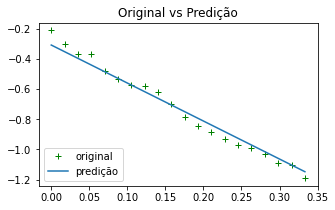

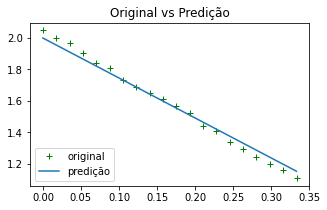

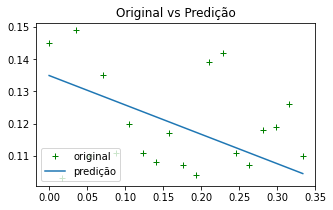

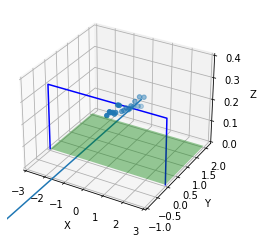

In [3]:
# dataset1 linear, linear, linear
GD_x = gradient_descent(100000, 0.001, time, x1, 1)
time1 = np.linspace(0, 2/3, 20)
x1_predicted = eval_1st_degree(GD_x[1], time1)
plt.figure(figsize=(5,3))
plt.plot(time, x1, 'g+', label = 'original')
plt.plot(time, GD_x[2], label = 'predição')
plt.title('Original vs Predição')
plt.legend(loc="lower left")
plt.show()

GD_y = gradient_descent(100000, 0.001, time, y1, 1)
time1 = np.linspace(0, 2, 20)
y1_predicted = eval_1st_degree(GD_y[1], time1)
plt.figure(figsize=(5,3))
plt.plot(time, y1, 'g+', label = 'original')
plt.plot(time, GD_y[2], label = 'predição')
plt.title('Original vs Predição')
plt.legend(loc="lower left")
plt.show()

GD_z = gradient_descent(100000, 0.001, time, z1, 1)
time1 = np.linspace(0, 2, 20)
z1_predicted = eval_1st_degree(GD_z[1], time1)
plt.figure(figsize=(5,3))
plt.plot(time, z1, 'g+', label = 'original')
plt.plot(time, GD_z[2], label = 'predição')
plt.title('Original vs Predição')
plt.legend(loc="lower left")
plt.show()

ax = plt.axes(projection='3d')
ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
Z = np.zeros(X.shape)
ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
ax.set_xlim(-3,3)
ax.set_ylim(-1,2.2)
ax.set_zlim(0, 0.4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter3D(x1, y1, z1);
ax.plot(x1_predicted, y1_predicted, z1_predicted)
plt.show()


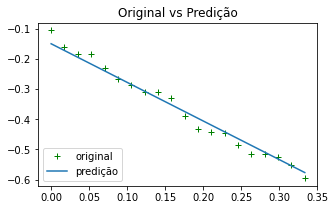

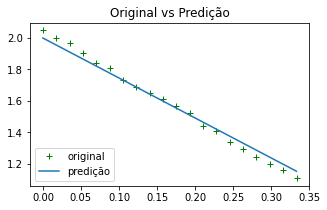

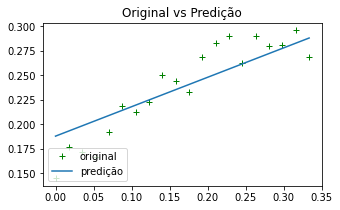

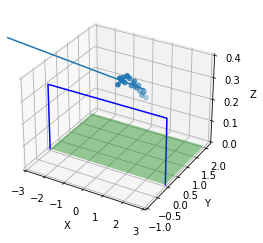

In [4]:
# dataset2 linear, linear, linear
GD_x = gradient_descent(100000, 0.001, time, x2, 1)
time1 = np.linspace(0, 2, 20)
x2_predicted = eval_1st_degree(GD_x[1], time1)
plt.figure(figsize=(5,3))
plt.plot(time, x2, 'g+', label = 'original')
plt.plot(time, GD_x[2], label = 'predição')
plt.title('Original vs Predição')
plt.legend(loc="lower left")
plt.show()

GD_y = gradient_descent(100000, 0.001, time, y2, 1)
time1 = np.linspace(0, 2, 20)
y2_predicted = eval_1st_degree(GD_y[1], time1)
plt.figure(figsize=(5,3))
plt.plot(time, y2, 'g+', label = 'original')
plt.plot(time, GD_y[2], label = 'predição')
plt.title('Original vs Predição')
plt.legend(loc="lower left")
plt.show()

GD_z = gradient_descent(100000, 0.001, time, z2, 1)
time1 = np.linspace(0, 2, 20)
z2_predicted = eval_1st_degree(GD_z[1], time1)
plt.figure(figsize=(5,3))
plt.plot(time, z2, 'g+', label = 'original')
plt.plot(time, GD_z[2], label = 'predição')
plt.title('Original vs Predição')
plt.legend(loc="lower left")
plt.show()

ax = plt.axes(projection='3d')
ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
Z = np.zeros(X.shape)
ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
ax.set_xlim(-3,3)
ax.set_ylim(-1,2.2)
ax.set_zlim(0, 0.4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter3D(x2, y2, z2)
ax.plot(x2_predicted, y2_predicted, z2_predicted)
plt.show()

Iteração  0


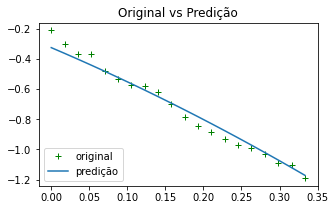

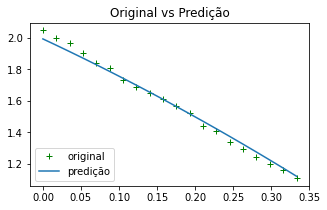

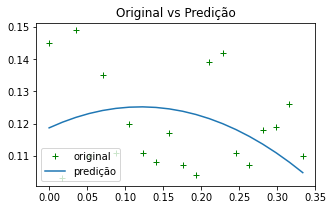

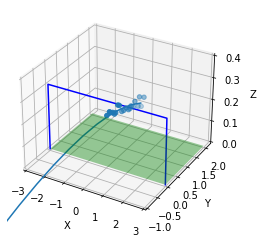

Iteração  1


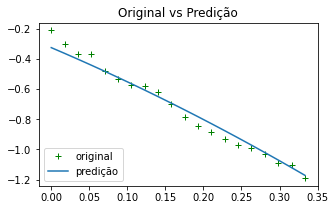

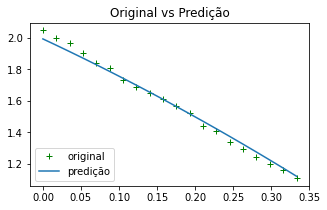

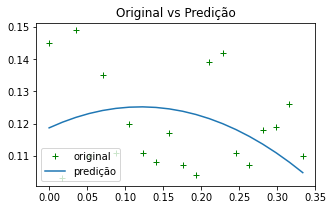

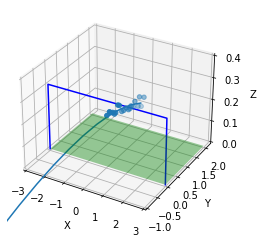

In [5]:
# dataset1 2nd, 2nd, 2nd
for i in range(2):
    print("Iteração ", i)
    time1 = np.linspace(0, 2, 20)
    
    GD_x = gradient_descent(100000, 0.001, time, x1, 2)
    GD_y = gradient_descent(100000, 0.001, time, y1, 2)
    GD_z = gradient_descent(100000, 0.001, time, z1, 2)
    y1_predicted = eval_2nd_degree(GD_y[1], time1)
    x1_predicted = eval_2nd_degree(GD_x[1], time1)
    z1_predicted = eval_2nd_degree(GD_z[1], time1)
    
    plt.figure(figsize=(5,3))
    plt.plot(time, x1, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, y1, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, z1, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x1, y1, z1);
    ax.plot(x1_predicted, y1_predicted, z1_predicted)
    plt.show()

Iteração  0


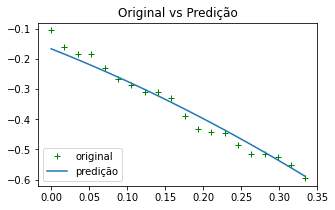

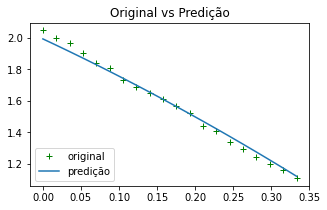

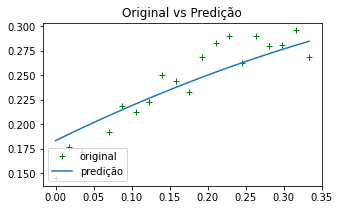

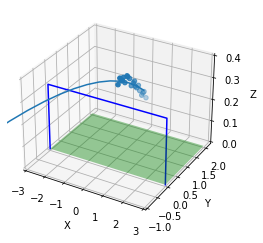

Iteração  1


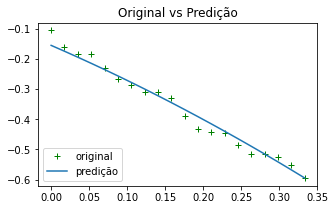

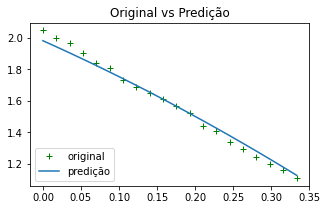

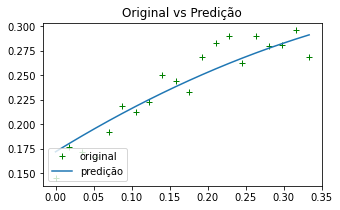

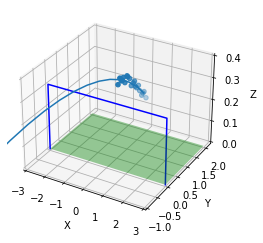

In [6]:
# dataset2 2nd, 2nd, 2nd
for i in range(2):
    print("Iteração ", i)
    time1 = np.linspace(0, 2, 20)
    
    GD_x = gradient_descent(100000, 0.001, time, x2, 2)
    GD_y = gradient_descent(100000, 0.001, time, y2, 2)
    GD_z = gradient_descent(100000, 0.001, time, z2, 2)
    
    y2_predicted = eval_2nd_degree(GD_y[1], time1)
    x2_predicted = eval_2nd_degree(GD_x[1], time1)
    z2_predicted = eval_2nd_degree(GD_z[1], time1)

    plt.figure(figsize=(5,3))
    plt.plot(time, x2, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, y2, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()

Iteração  0


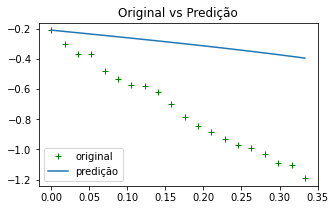

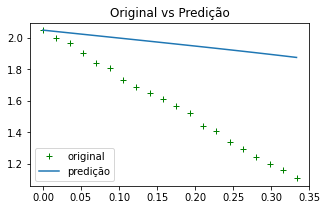

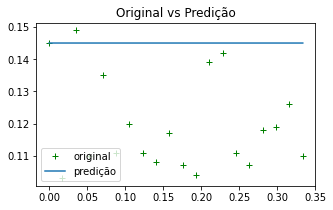

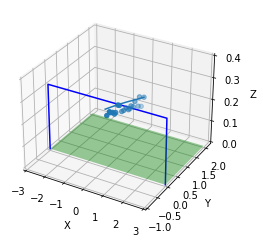

Iteração  1


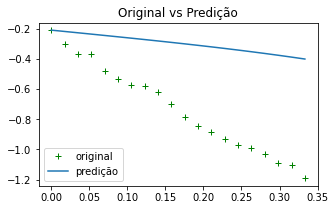

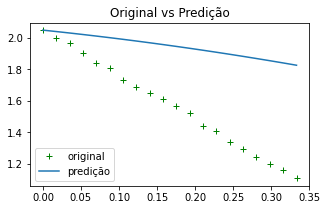

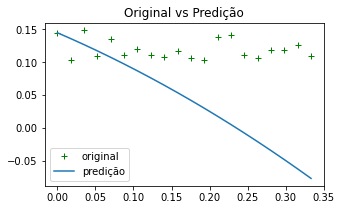

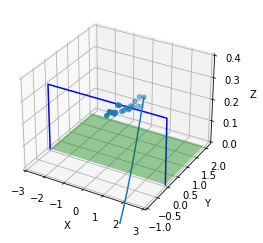

In [7]:
# dataset1 4th, 4th, 4th
for i in range(2):
    print("Iteração ", i)
    time1 = np.linspace(0, 1, 20)
    
    GD_x = gradient_descent(100000, 0.001, time, x1, 4)
    GD_y = gradient_descent(100000, 0.001, time, y1, 4)
    GD_z = gradient_descent(100000, 0.001, time, z1, 4)
    y1_predicted = eval_4th_degree(GD_y[1], time1)
    x1_predicted = eval_4th_degree(GD_x[1], time1)
    z1_predicted = eval_4th_degree(GD_z[1], time1)
    
    plt.figure(figsize=(5,3))
    plt.plot(time, x1, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, y1, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, z1, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x1, y1, z1);
    ax.plot(x1_predicted, y1_predicted, z1_predicted)
    plt.show()

Iteração  0


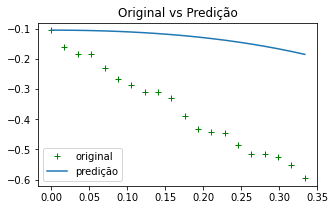

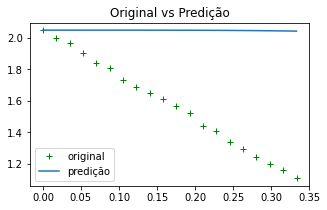

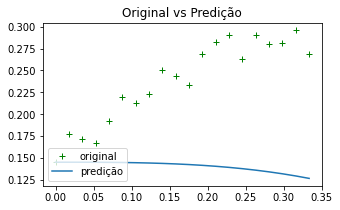

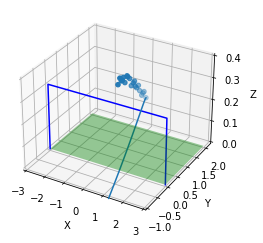

Iteração  1


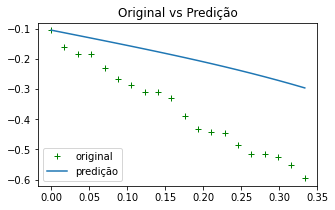

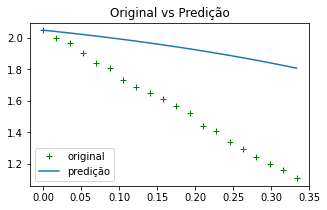

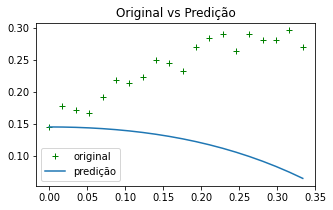

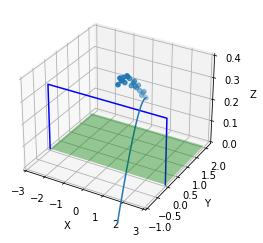

In [8]:
# dataset2 4th, 4th, 4th
for i in range(2):
    print("Iteração ", i)
    time1 = np.linspace(0, 1, 20)
    
    GD_x = gradient_descent(100000, 0.001, time, x2, 4)
    GD_y = gradient_descent(100000, 0.001, time, y2, 4)
    GD_z = gradient_descent(100000, 0.001, time, z2, 4)
    y2_predicted = eval_4th_degree(GD_y[1], time1)
    x2_predicted = eval_4th_degree(GD_x[1], time1)
    z2_predicted = eval_4th_degree(GD_z[1], time1)
    #plt.figure(figsize=(20,10))
    plt.figure(figsize=(5,3))
    plt.plot(time, x2, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, y2, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()

Iteração  0


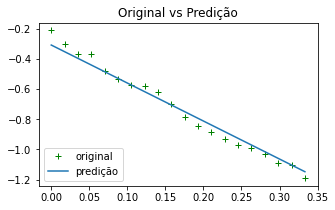

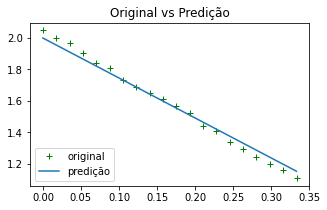

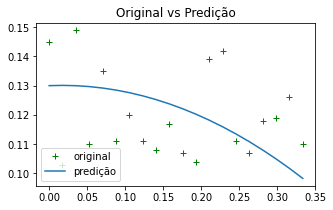

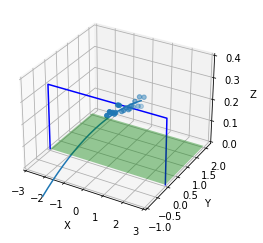

Iteração  1


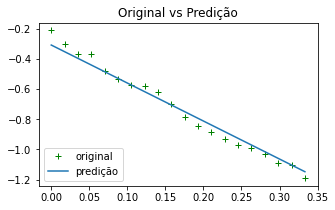

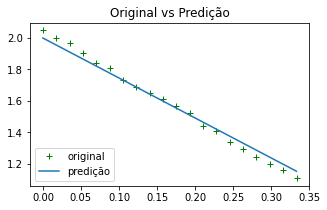

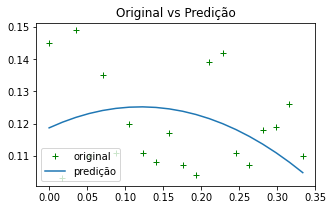

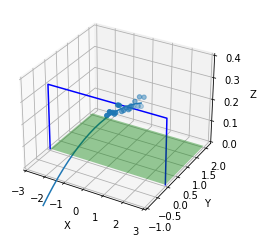

Iteração  2


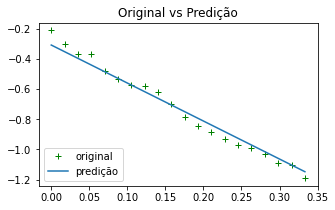

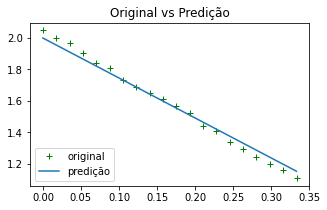

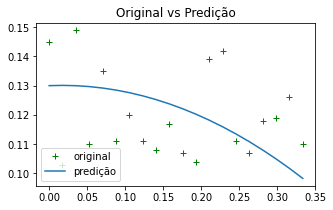

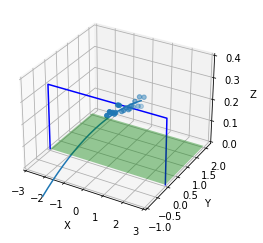

Iteração  3


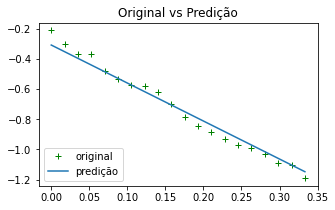

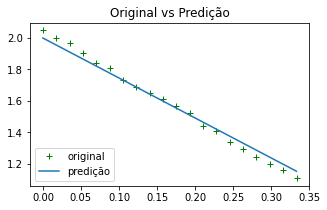

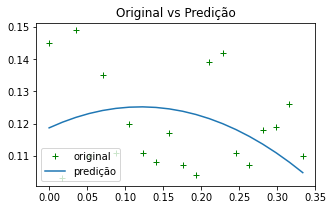

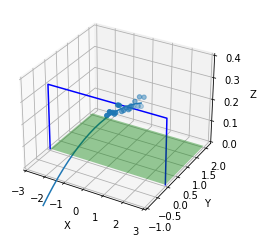

Iteração  4


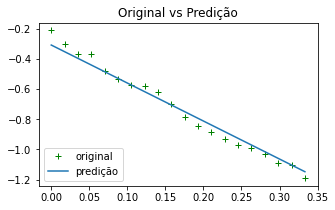

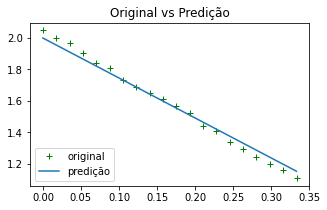

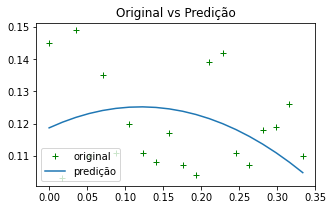

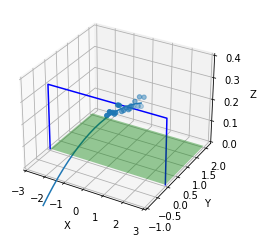

In [9]:
# dataset1 linear, linear, 2nd
for i in range(5):
    print("Iteração ", i)
    time1 = np.linspace(0, 1, 20)
    GD_x = gradient_descent(100000, 0.001, time, x1, 1)
    x1_predicted = eval_1st_degree(GD_x[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, x1, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    GD_y = gradient_descent(100000, 0.001, time, y1, 1)
    y1_predicted = eval_1st_degree(GD_y[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, y1, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    GD_z= gradient_descent(100000, 0.001, time, z1, 2)
    z1_predicted = eval_2nd_degree(GD_z[1], time1)
   
    plt.figure(figsize=(5,3))
    plt.plot(time, z1, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x1, y1, z1);
    ax.plot(x1_predicted, y1_predicted, z1_predicted)
    plt.show()

Iteração  0


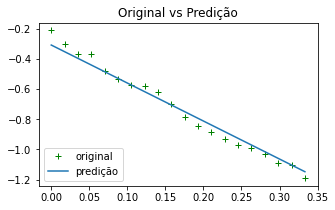

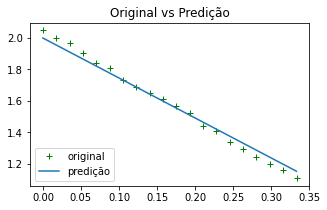

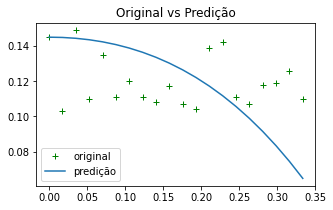

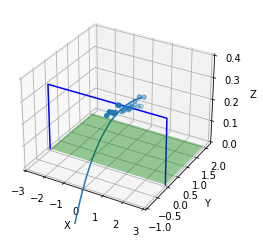

In [10]:
# dataset1 linear, linear, 4th
for i in range(1):
    print("Iteração ", i)
    time1 = np.linspace(0, 1, 20)
    
    GD_x = gradient_descent(100000, 0.001, time, x1, 1)
    x1_predicted = eval_1st_degree(GD_x[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, x1, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    GD_y = gradient_descent(100000, 0.001, time, y1, 1)
    y1_predicted = eval_1st_degree(GD_y[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, y1, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    GD_z = gradient_descent(100000, 0.001, time, z1, 4)
    z1_predicted = eval_4th_degree(GD_z[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, z1, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x1, y1, z1);
    ax.plot(x1_predicted, y1_predicted, z1_predicted)
    plt.show()

Iteração  0


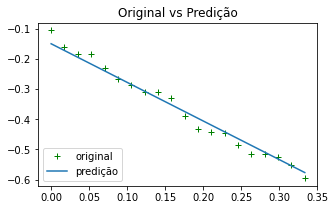

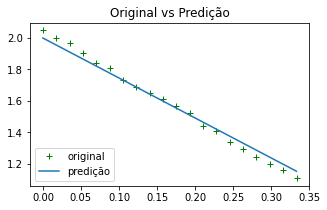

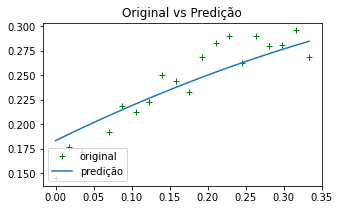

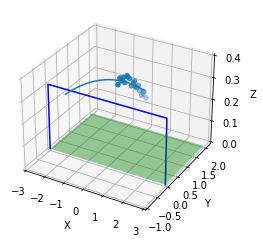

Iteração  1


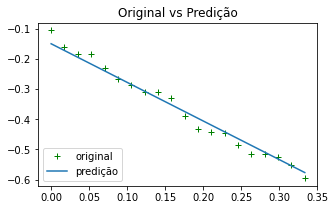

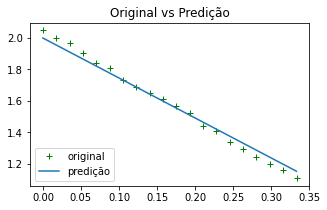

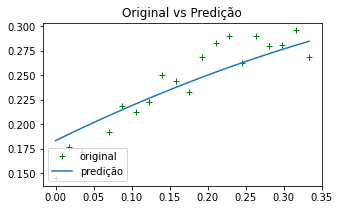

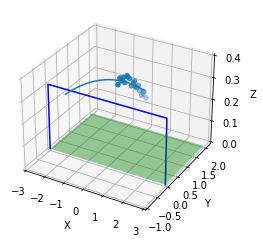

Iteração  2


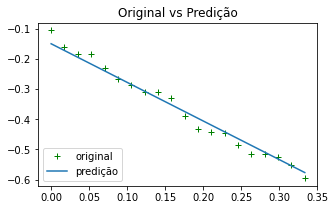

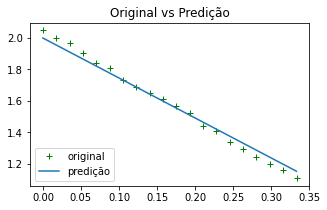

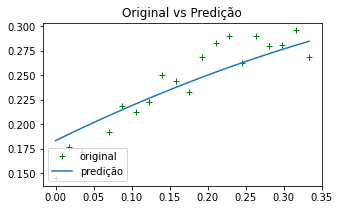

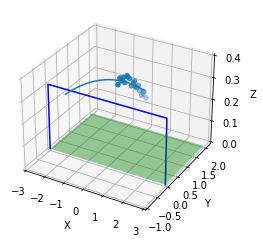

Iteração  3


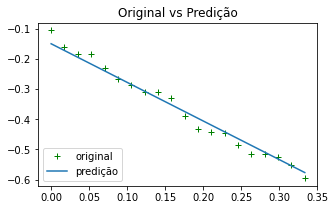

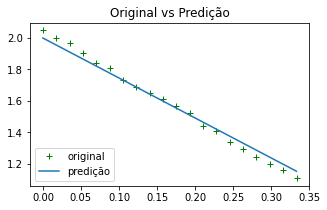

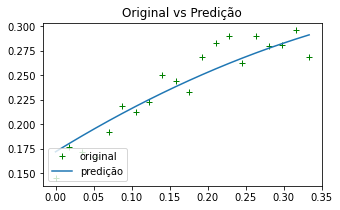

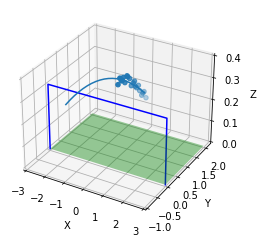

Iteração  4


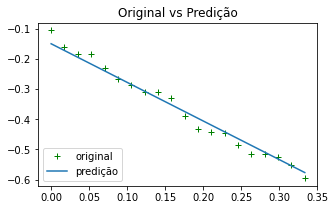

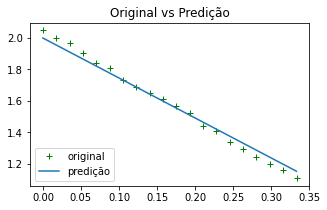

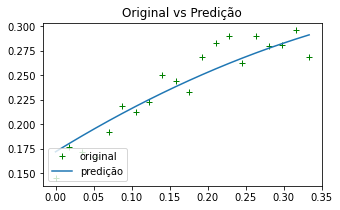

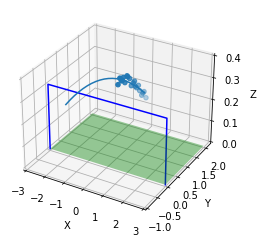

In [11]:
# dataset2 linear, linear, 2nd
for i in range(5):
    print("Iteração ", i)
    time1 = np.linspace(0, 1, 20)
    GD_x = gradient_descent(100000, 0.001, time, x2, 1)
    x2_predicted = eval_1st_degree(GD_x[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, x2, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    GD_y = gradient_descent(100000, 0.001, time, y2, 1)
    y2_predicted = eval_1st_degree(GD_y[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, y2, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    GD_z = gradient_descent(100000, 0.001, time, z2, 2)
    z2_predicted = eval_2nd_degree(GD_z[1], time1)  
    plt.figure(figsize=(5,3))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()

Iteração  0


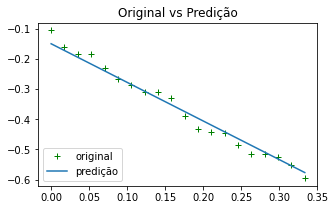

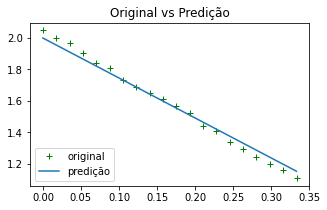

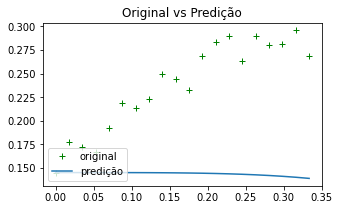

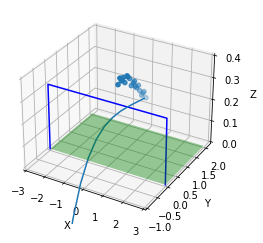

In [12]:
# dataset2 linear, linear, 4th
for i in range(1):
    print("Iteração ", i)
    time1 = np.linspace(0, 2, 20)
    GD_x = gradient_descent(100000, 0.001, time, x2, 1)
    x2_predicted = eval_1st_degree(GD_x[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, x2, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    GD_y = gradient_descent(100000, 0.001, time, y2, 1)
    y2_predicted = eval_1st_degree(GD_y[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, y2, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()
    
    GD_z = gradient_descent(100000, 0.001, time, z2, 4)
    z2_predicted = eval_4th_degree(GD_z[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()

# Impacto da *learning rate* para o processo do Gradient Descent

Quanto menor é a *learning rate*, maior é o número necessário de iterações para que o *Gradient Descent* consiga obter convergência em uma solução. No entanto, existem uma certa nuance - uma *learning rate* muito alta pode causar uma convergência em uma solução ruim, enquanto que uma *learning rate* muito baixa pode deixar o *Gradient Descent* sem encontrar uma solução boa também. Abaixo temos os gráficos das variáveis $x$, $y$ e $z$ submetidas ao modelo que consideramos ideal - regressões lineares para $x$ e $y$ e polinomial de segundo grau para $z$. Utilizamos $100000$ iterações e testamos três *learning rates* - $0.001$, $0.0001$ e $0.0000001$. Além disso, abaixo de cada gráfico da variável em relação ao tempo, temos também um gráfico que apresenta a diminuição do valor do MSE a cada uma das $100000$ iterações.

Podemos notar claramente que conforme diminuímos a *learning rate*, o valor do MSE ao longo das iterações varia pouco - o que faz sentido, já que estamos subtraindo um valor cada vez menor ao longo das iterações. E isto tem impacto direto nos coeficientes finais da regressão. Isto fica claro para a *learning rate* de $0.0000001$, o que indica que deveríamos, por exemplo, aumentar este número de iterações para que o algoritmo do *Gradient Descent* tivesse tempo de chegar em uma solução melhor.

Por outro lado, vemos que uma *learning rate* de $0.001$ já mostra uma diminuição significativa do MSE ao final das $100000$ iterações, que é um bom indício de que seja uma *learning rate* que pode ser usada com confiança.

Learning Rate:  0.001


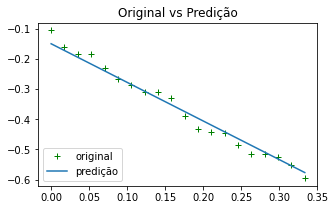

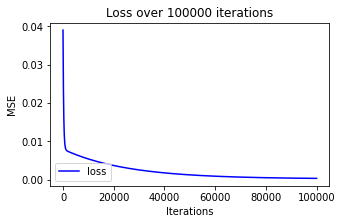

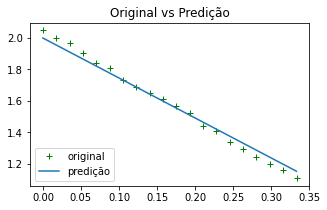

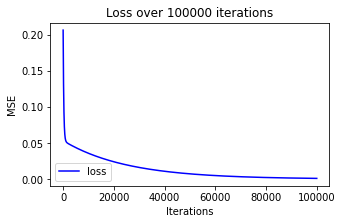

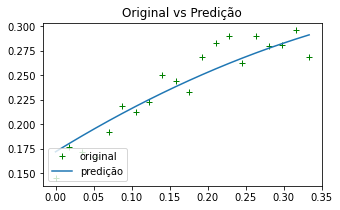

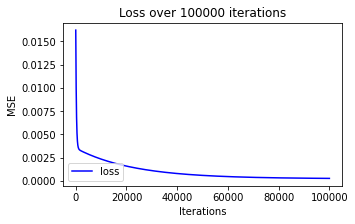

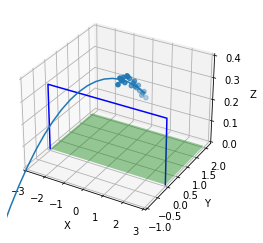

Learning Rate:  0.0001


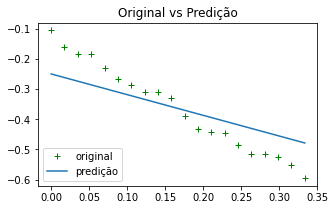

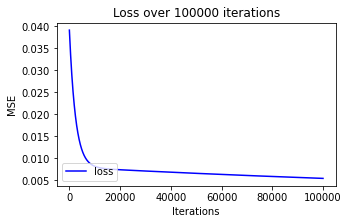

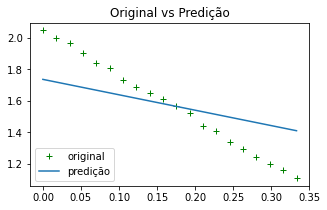

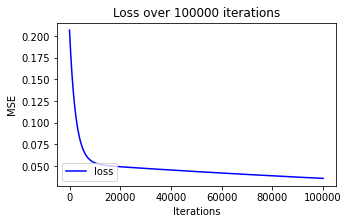

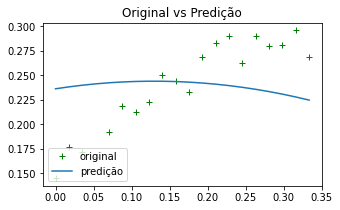

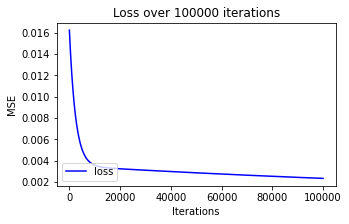

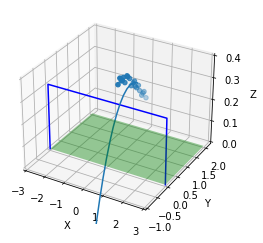

Learning Rate:  1e-07


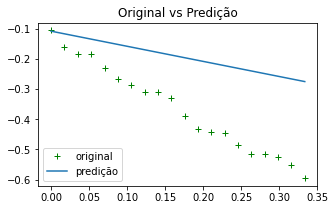

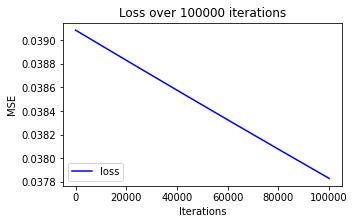

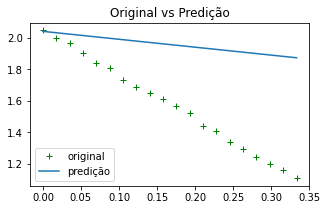

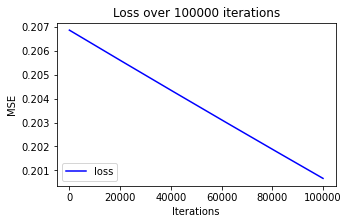

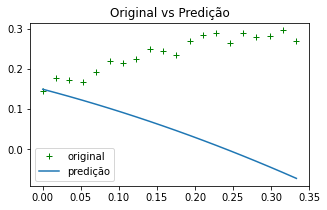

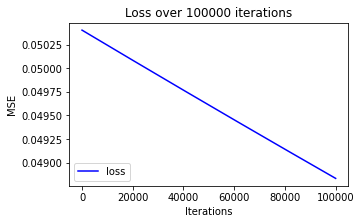

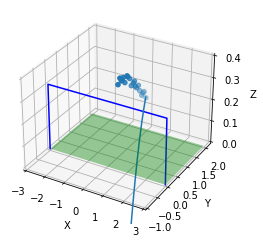

In [13]:
# dataset2 linear, linear, 2nd
lr = [0.001,0.0001,0.0000001]
for i in range(3):
    print("Learning Rate: ", lr[i])
    time1 = np.linspace(0, 2, 20)
    GD_x = gradient_descent(100000, lr[i], time, x2, 1)
    x2_predicted = eval_1st_degree(GD_x[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, x2, 'g+', label = 'original')
    plt.plot(time, GD_x[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    plt.figure(figsize=(5,3))
    plt.plot(GD_x[3], 'b-', label = 'loss')
    plt.title('Loss over 100000 iterations')
    plt.legend(loc="lower left")
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.show()

    GD_y = gradient_descent(100000, lr[i], time, y2, 1)
    y2_predicted = eval_1st_degree(GD_y[1], time1)
    plt.figure(figsize=(5,3))
    plt.plot(time, y2, 'g+', label = 'original')
    plt.plot(time, GD_y[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    plt.figure(figsize=(5,3))
    plt.plot(GD_y[3], 'b-', label = 'loss')
    plt.title('Loss over 100000 iterations')
    plt.legend(loc="lower left")
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.show()

    GD_z = gradient_descent(100000, lr[i], time, z2, 2)
    z2_predicted = eval_2nd_degree(GD_z[1], time1)  
    plt.figure(figsize=(5,3))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD_z[2], label = 'predição')
    plt.title('Original vs Predição')
    plt.legend(loc="lower left")
    plt.show()

    plt.figure(figsize=(5,3))
    plt.plot(GD_z[3], 'b-', label = 'loss')
    plt.title('Loss over 100000 iterations')
    plt.legend(loc="lower left")
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.show()

    ax = plt.axes(projection='3d')
    ax.plot([-3,-3,3,3], [0,0.3,0.3,0], zdir='y', zs=0, c= 'b')
    X, Y = np.meshgrid(np.linspace(-3,3,2), np.linspace(0,2,2))
    Z = np.zeros(X.shape)
    ax.plot_surface(X, Y, Z, shade=False, color='g', alpha=.4)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2.2)
    ax.set_zlim(0, 0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()

# Conclusão: O goleiro será capaz de defender os chutes?

Consideramos que o goleiro consegue alcançar a bola se ela estiver em seu raio de ação, ou seja, dentro de uma distância de $1$ metro tanto para a direita, quanto para a esquerda. Isso significa que se a bola passar por um ponto dentro do intervalo $[-1,1]$ para o eixo $x$ ao cruzar $y = 0$, temos que o goleiro defendeu a bola. Como nossas funções trabalham em relação tempo, o que precisamos fazer é descobrir o valor de $t$ para $y = 0$ e jogar este valor na função obtida da regressão de $x$ e avaliar seu valor.

Vamos analisar as funções de $x$ e $y$ a partir de suas regressões lineares, pois como discutido anteriormente, consideramos que este é o grau ideal de polinomio para este conjunto de dados.

In [14]:
for i in range(5):
    print("Iteração ", i)
    # Dataset 1
    print("Dataset 1")
    GD_y = gradient_descent(100000, 0.001, time, y1, 1)
    t = -GD_y[1][0]/GD_y[1][1]
    print("Valor de t para y = 0:",t, "s")
    GD_x = gradient_descent(100000, 0.001, time, x1, 1)
    x1_predicted = eval_1st_degree(GD_x[1], np.array(t))
    print("Valor de x1: ", x1_predicted)
    print("------------------------------------------------------")
    print()
    # Dataset 2
    print("Dataset 2")
    GD_y = gradient_descent(100000, 0.001, time, y2, 1)
    y2_predicted = eval_1st_degree(GD_y[1], time1)
    t = -GD_y[1][0]/GD_y[1][1]
    print("Valor de t para y = 0:", t, "s")
    GD_x = gradient_descent(100000, 0.001, time, x2, 1)
    x2_predicted = eval_1st_degree(GD_x[1], np.array(t))
    print("Valor de x1: ", x2_predicted)
    print("______________________________________________________")
    print()


Iteração  0
Dataset 1
Valor de t para y = 0: 1.2672235783463677 s
Valor de x1:  -3.498436525123164
------------------------------------------------------

Dataset 2
Valor de t para y = 0: 1.2672235783463677 s
Valor de x1:  -1.7717557208538164
______________________________________________________

Iteração  1
Dataset 1
Valor de t para y = 0: 1.2672235783463677 s
Valor de x1:  -3.498436525123164
------------------------------------------------------

Dataset 2
Valor de t para y = 0: 1.2672235783463677 s
Valor de x1:  -1.7717557208538164
______________________________________________________

Iteração  2
Dataset 1
Valor de t para y = 0: 1.2672235783463677 s
Valor de x1:  -3.498436525123164
------------------------------------------------------

Dataset 2
Valor de t para y = 0: 1.2672235783463677 s
Valor de x1:  -1.7717557208538164
______________________________________________________

Iteração  3
Dataset 1
Valor de t para y = 0: 1.2672235783463677 s
Valor de x1:  -3.498436525123164
----

Para o dataset $1$, temos que em $y=0$, rodando $5$ iterações, o valor fica em aproximadamente $x = -3.49$. Vemos que, na realidade, para o dataset $1$ a bola não chega a cruzar $y = 0$ dentro dos limites do gol, que são de $[-3,3]$. Logo, o goleiro não precisa se preocupar com defender ou não os chutes.

Para o dataset $2$, temos que em $y=0$, rodando $5$ iterações, o valor fica em aproximadamente $x = -1.77$. Este valor de $x$ está dentro dos limites do gol, porém foge da distância de $[-1,1]$ dentro da qual o goleiro é capaz de defender a bola; portanto, temos que o goleiro não é capaz de defender a bola do dataset $2$.

# Classification task

Nesta parte do trabalho iremos resolver um problema de classificação usando métodos supervisionados. Iremos trabalhar com o dataset "Pen-Based Recognition of Handwritten Digits", que consiste em imagens de 8x8 pixels em escala de cinza divididas em 10 classes.

In [25]:
digits = load_digits()
print('Tamanho do dataset: ', digits.data.shape)
print('Pixels da imagem: ', digits.images[0].shape)

print('\nQuantidade de amostras em cada classe:\n')

for i in range(10):
    print('Classe {}: {} amostras'.format(i, len(digits.target[digits.target == i])))

Tamanho do dataset:  (1797, 64)
Pixels da imagem:  (8, 8)

Quantidade de amostras em cada classe:

Classe 0: 178 amostras
Classe 1: 182 amostras
Classe 2: 177 amostras
Classe 3: 183 amostras
Classe 4: 181 amostras
Classe 5: 182 amostras
Classe 6: 181 amostras
Classe 7: 179 amostras
Classe 8: 174 amostras
Classe 9: 180 amostras


#### Classes do problema

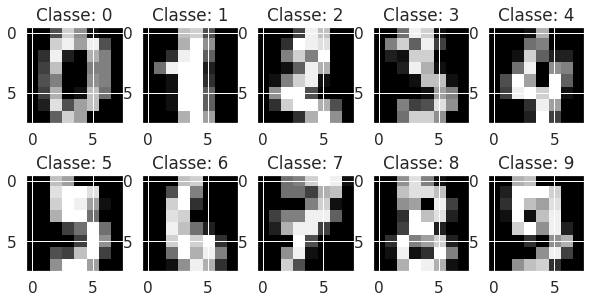

In [11]:
plt.figure(figsize=(10, 5))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(digits.images[i-1], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.title('Classe: {}'.format(i-1))
plt.show()

#### Separação dos dados em treino e teste

Separamos 90% dos dados para treinamento e 10% dos dados para teste, e fixamos o seed em 42 para sempre obtermos o mesmo dataset da análise.

In [4]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.1, random_state=42)

#### Aplicando a transformação MinMaxScaler 

Transformando os dados em um intervalo de 0 a 1, para ajudar os modelos a generalizarem.

In [5]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

### T-SNE

O T-SNE é um método para visualizar dados de alta dimensão, dando a cada ponto de dados uma localização em um mapa bidimensional ou tridimensional.

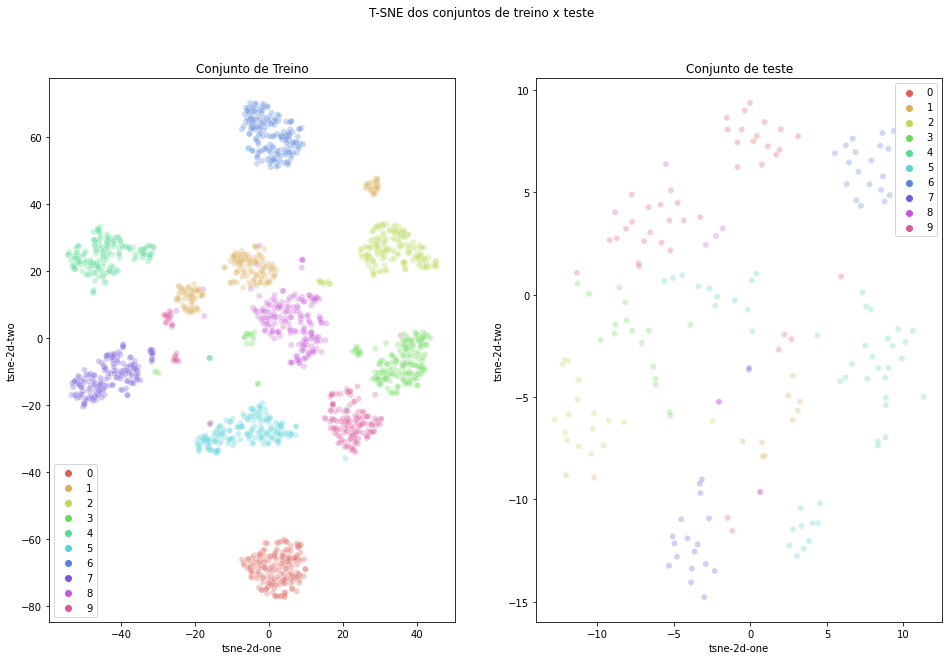

In [6]:
X_embedded_train = TSNE(n_components=2).fit_transform(X_train)
X_embedded_test = TSNE(n_components=2).fit_transform(X_test)

df_subset = pd.DataFrame()
df_test = pd.DataFrame()
df_subset['tsne-2d-one'] = X_embedded_train[:,0]
df_subset['tsne-2d-two'] = X_embedded_train[:,1]
df_test['tsne-2d-one'] = X_embedded_test[:,0]
df_test['tsne-2d-two'] = X_embedded_test[:,1]

plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_train,
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.title('Conjunto de Treino')
plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_test,
    palette=sns.color_palette("hls", 10),
    data=df_test,
    legend="full",
    alpha=0.3
)
plt.title('Conjunto de teste')
plt.suptitle('T-SNE dos conjuntos de treino x teste')

plt.show()

### Treinamento e classificação

Escolhemos aplicar os modelos SVC e DecisionTree e para escolher os melhores parâmetros iremos aplicar o GridSearchCV (busca exaustiva sobre parâmetros). O GridSearchCV aplica validação cruzada para avaliar os modelos e depois escolhe o melhor de acordo com a métrica que gostariamos que fosse mais importante.

Aplicaremos GridSearchCV buscando os melhores hiper-parâmetros para os modelos em função das métricas: precisão, recall, f1 e acurácia. Para os melhores resultados também analisaremos a matrix de confusão.

Como o dataset não é desbalanceado podemos aplicar as métricas do tipo 'micro' para que ela calcule globalmente o total de verdadeiros positivos, falsos negativos e falsos positivos.

------------------------------------------------------------------
# Melhorando hiper-parâmetros para precision_micro 

Melhores hiper-parâmetros encontrados: {'C': 1, 'kernel': 'linear'}

 Resultados do Grid: 

0.529 (+/-0.029) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.106 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.541 (+/-0.021) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.008) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.010) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.978 (+/-0.010) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.981 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 100, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 1000, 'kernel': 'linear'}

 Resultado detalhado da classificação:
Aplicando o conjunto d

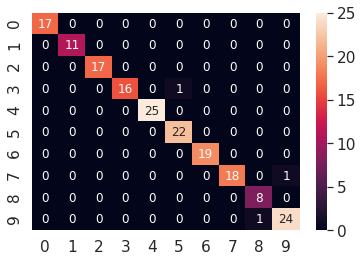

------------------------------------------------------------------
# Melhorando hiper-parâmetros para recall_micro 

Melhores hiper-parâmetros encontrados: {'C': 1, 'kernel': 'linear'}

 Resultados do Grid: 

0.529 (+/-0.029) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.106 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.541 (+/-0.021) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.008) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.010) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.978 (+/-0.010) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.981 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 100, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 1000, 'kernel': 'linear'}

 Resultado detalhado da classificação:
Aplicando o conjunto de t

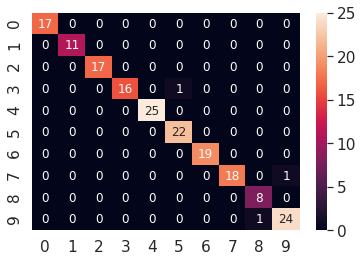

------------------------------------------------------------------
# Melhorando hiper-parâmetros para f1_micro 

Melhores hiper-parâmetros encontrados: {'C': 1, 'kernel': 'linear'}

 Resultados do Grid: 

0.529 (+/-0.029) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.106 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.541 (+/-0.021) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.008) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.010) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.978 (+/-0.010) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.981 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 100, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 1000, 'kernel': 'linear'}

 Resultado detalhado da classificação:
Aplicando o conjunto de teste

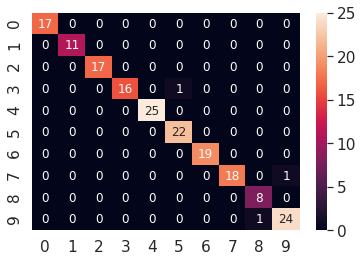

------------------------------------------------------------------
# Melhorando hiper-parâmetros para accuracy 

Melhores hiper-parâmetros encontrados: {'C': 1, 'kernel': 'linear'}

 Resultados do Grid: 

0.529 (+/-0.029) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.106 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.541 (+/-0.021) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.008) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.954 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.010) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.978 (+/-0.010) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.981 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 100, 'kernel': 'linear'}
0.980 (+/-0.011) for {'C': 1000, 'kernel': 'linear'}

 Resultado detalhado da classificação:
Aplicando o conjunto de teste

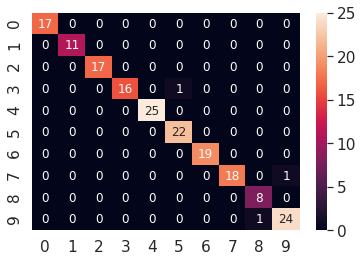

In [32]:
# Parâmetros escolhidos 
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# Métricas escolhidas
scores = ['precision_micro', 'recall_micro', 'f1_micro', 'accuracy']


for score in scores:
    print('------------------------------------------------------------------')
    print("# Melhorando hiper-parâmetros para %s \n" % score)
   

    clf = GridSearchCV(SVC(), tuned_parameters, scoring=score)
    clf.fit(X_train, y_train)

    print("Melhores hiper-parâmetros encontrados: {}".format(clf.best_params_))
   
    print("\n Resultados do Grid: \n")

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    

    print("\n Resultado detalhado da classificação:")
    print("Aplicando o conjunto de teste")
    
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

    conf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(conf_matrix, range(10), range(10))

    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

    plt.show()
    


------------------------------------------------------------------
# Melhorando hiper-parâmetros para precision_micro 

Melhores hiper-parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2}

 Resultados do Grid: 

0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4}
0.470 (+/-0.024) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
0.470 (+/-0.024

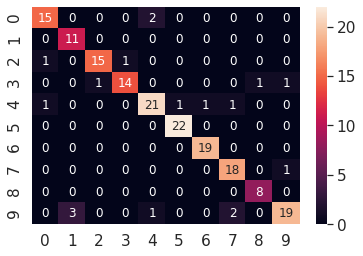

------------------------------------------------------------------
# Melhorando hiper-parâmetros para recall_micro 

Melhores hiper-parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2}

 Resultados do Grid: 

0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4}
0.470 (+/-0.024) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
0.470 (+/-0.024) f

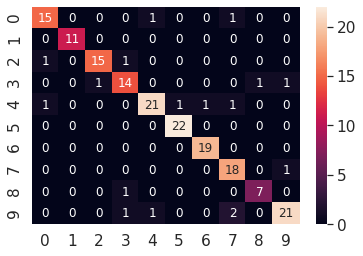

------------------------------------------------------------------
# Melhorando hiper-parâmetros para f1_micro 

Melhores hiper-parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2}

 Resultados do Grid: 

0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4}
0.470 (+/-0.024) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
0.470 (+/-0.024) for {

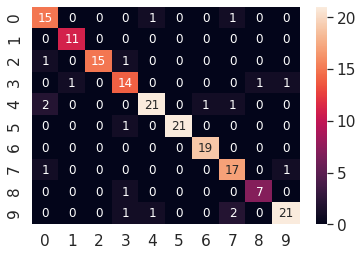

------------------------------------------------------------------
# Melhorando hiper-parâmetros para accuracy 

Melhores hiper-parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1}

 Resultados do Grid: 

0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3}
0.203 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3}
0.321 (+/-0.005) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4}
0.470 (+/-0.024) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
0.470 (+/-0.024) for {

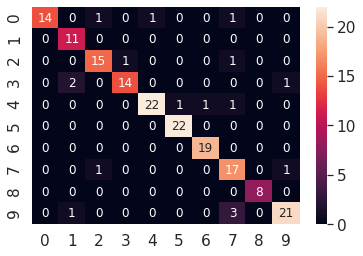

In [33]:
tuned_parameters = {"criterion":["gini", "entropy"],"max_depth": range(1,10), 
         "min_samples_leaf": range(1,5)}


scores = ['precision_micro', 'recall_micro', 'f1_micro', 'accuracy']


for score in scores:
    print('------------------------------------------------------------------')
    print("# Melhorando hiper-parâmetros para %s \n" % score)
   

    clf = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring=score)
    clf.fit(X_train, y_train)

    print("Melhores hiper-parâmetros encontrados: {}".format(clf.best_params_))
   
    print("\n Resultados do Grid: \n")

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    

    print("\n Resultado detalhado da classificação:")
    print("Aplicando o conjunto de teste")
    
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

    conf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(conf_matrix, range(10), range(10))

    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

    plt.show()